# Sequency Quick Start

[Sequency](https://mathworld.wolfram.com/Sequency.html) Analysis

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import hotstepper.samples as samples
from hotstepper import Steps,Step
import hotstepper as hs
from hotstepper import Sequency

An exciting new sub-module of HotStepper is called Sequency. While that doesn't sound like much, the module will continue to be developed as refinements to the code and further use cases are shown or explained.

In short, Sequency analysis is the step function equivalent of Fourier Analysis, instead of using Sine and Cosine functions, the decomposition basis are [Walsh Functions](https://en.wikipedia.org/wiki/Walsh_function). As a very quick demonstration of what sequency analysis can do and how this is similar to Fourier analysis, this notebook works some analysis and investigation use cases to provide some guidance.

Also, in the interest of completeness, the Sequency module has also implemented a very basic Fast Fourier transform method.

In [2]:
seq = Sequency()
n,w = seq.walsh_matrix(8)

As an example of what the binary step versions of the orthgonal Walch basis functions look like, we plot the first 16 of them below. They in a crude way represent the step function equivalents of Sine and Cosines that can be used to decompose a periodic signal using Fourier analysis. Step functions with repeating patterns can equally be decomposed into Walsh basis functions. Instead of each function having a frequency associated with it, Walsh functions use a Sequency number that represents the number of zero crossings over the range for that function. The Walsh functions below are plotted in order of increasing sequency number.

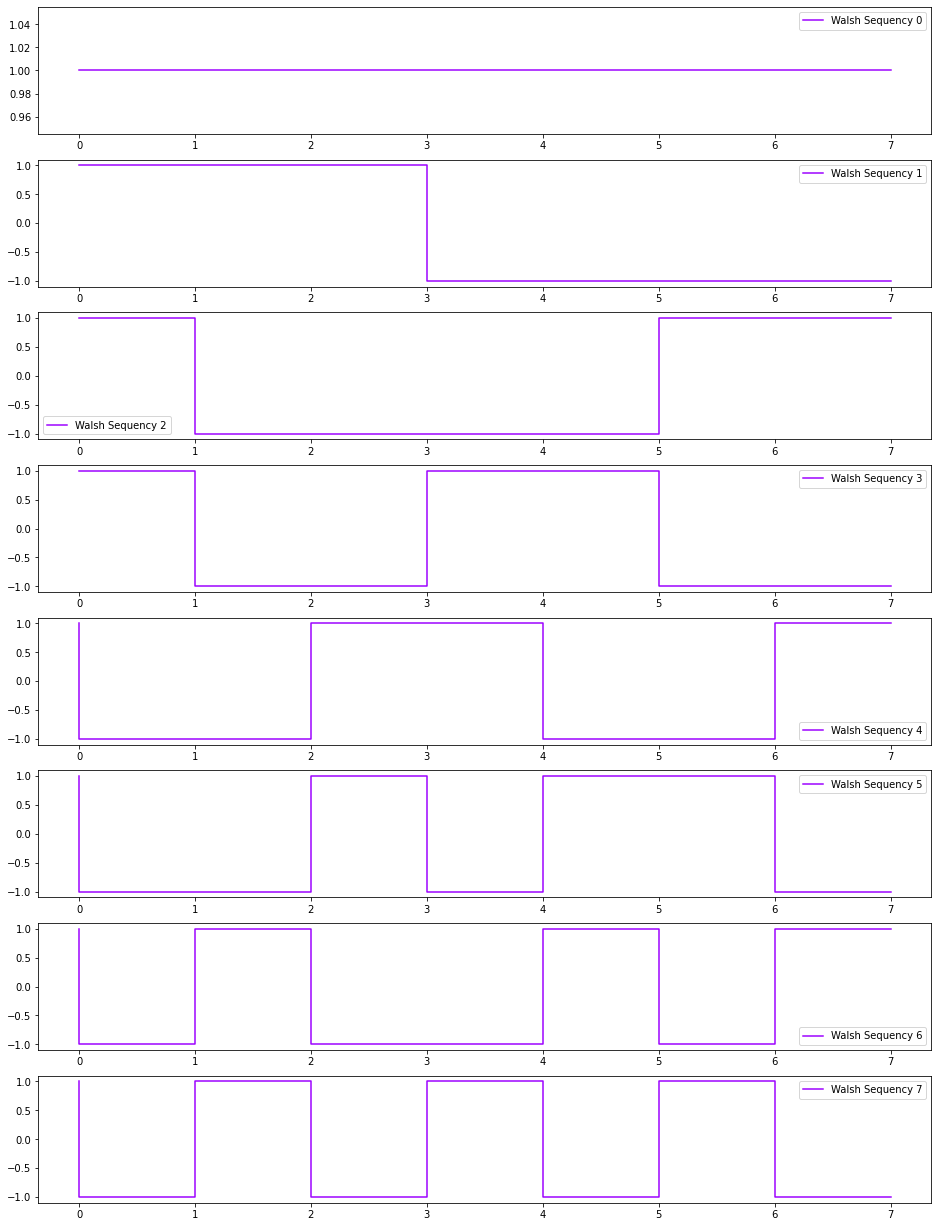

In [3]:
fig,ax = plt.subplots(nrows=8,figsize=(16,22))

for i in range(8):
    ax[i].step(n,w[i],label = 'Walsh Sequency {}'.format(i));
    ax[i].legend()

Now, let's say we have a step function and wish to understand the types of step changes that are most common to least common within that function, we can use a number of the existing analysis tools in HotStepper, however a more powerful and general method, especially familiar to anyone who has performed any Fourier analysis to answer similar questions with continuous time series is to use the Sequency sub module of HotStepper and perform a Walsh Sequency Spectrum analysis.

<AxesSubplot:>

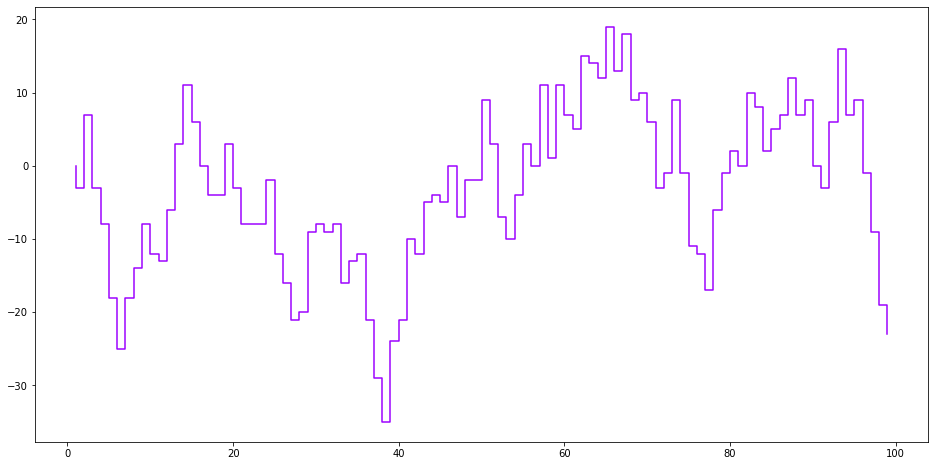

In [4]:
#Create a sequence of steps that we can analyse
steps_changes = np.random.randint(-10,12,100)

rand_steps = Steps().add_direct(data_start=list(range(1,len(steps_changes))),data_weight = steps_changes)
rand_steps.plot()

We create a dedicated sequency analysis object so, if we wanted to resuse it or create another with different parameters, we can keep everything seperated and organised. As tis sub-module matures, this will be the case, for now there isn't a strong immediate need for this seperation.

<StemContainer object of 3 artists>

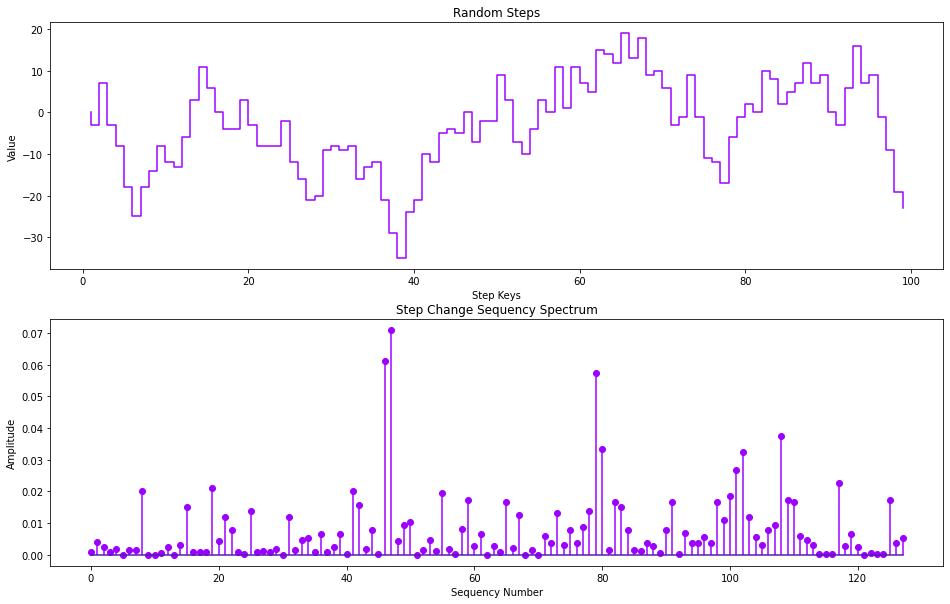

In [5]:
fig, (ax,ax2) = plt.subplots(nrows=2,figsize=(16,10))

# Sequency object to use for analysis
rand_step_seq = Sequency()


n,sp,l = rand_step_seq.sequency_spectrum(rand_steps.step_changes())

ax.set_title('Random Steps')
ax.set_xlabel('Step Keys')
ax.set_ylabel('Value')
rand_steps.plot(ax=ax)

ax2.set_title('Step Change Sequency Spectrum')
ax2.set_xlabel('Sequency Number')
ax2.set_ylabel('Amplitude')
ax2.stem(n,sp)


ok, great, what does that actually mean? Sequency analysis isn't mainstream, so I'm not surprised if you don't understand straight away, as it seems odd at first. Ok, let's look at say the top 5 sequencies that are present within the analysis steps data.

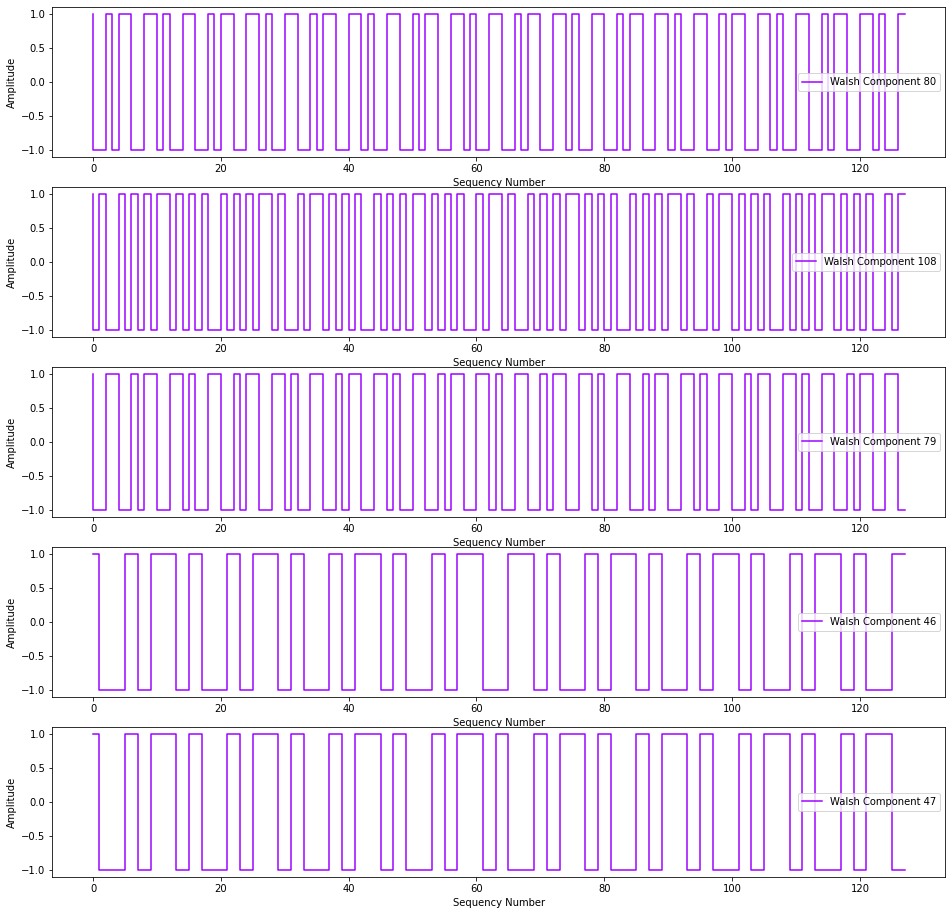

In [6]:
top5_indexes = np.argsort(sp)
top5_sequencies = n[top5_indexes][-5:]
top5_weight = sp[top5_indexes][-5:]

n,w = seq.walsh_matrix(l)

fig,ax = plt.subplots(nrows=5,figsize=(16,16))
i = 0
top5_walsh = np.zeros(l)

for seqy in top5_sequencies:
    top5_walsh += np.multiply(w[seqy],top5_weight[i])
    ax[i].step(n,w[seqy],label = 'Walsh Component {}'.format(seqy))
    ax[i].set_xlabel('Sequency Number')
    ax[i].set_ylabel('Amplitude')
    ax[i].legend();
    i +=1


Another typical use case of Fourier transforms is to remove high frequency noise from a single by decomposing it into constituent frequency components and setting frequencies below a threshold value to zero. With Sequency analysis, we have a similar functionality, except since we have step data and we are wanting to retain the nature of the step data (as steps) instead of just smoothing away the details, we can use the denoise method of the Sequency module to remove the higher sequency number components. An explicit example is shown below, here for now, we pass in the direct steps data for denoising, apply a strength parameter to determine how many of the high sequency components are set to zero and then we construct a new Steps object.


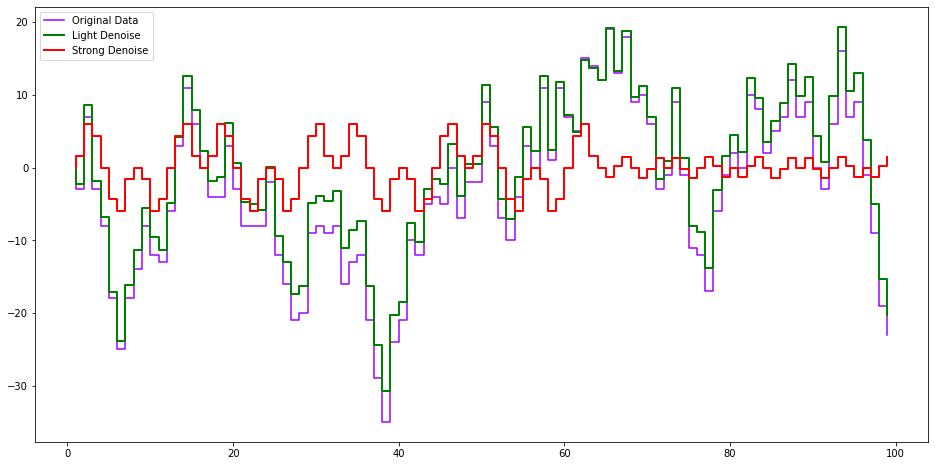

In [29]:
denoise_step_changes_strong = seq.denoise(rand_steps.step_changes(),denoise_strength=0.75)
denoise_step_changes = seq.denoise(rand_steps.step_changes(),denoise_strength=0.1)

rand_steps_denoise_strong = Steps().add_direct(data_start=rand_steps.step_keys(),data_weight = denoise_step_changes_strong)
rand_steps_denoise = Steps().add_direct(data_start=rand_steps.step_keys(),data_weight = denoise_step_changes)

ax = rand_steps.plot(label='Original Data')
rand_steps_denoise.plot(ax=ax,color='g',linewidth=2,label='Light Denoise');
rand_steps_denoise_strong.plot(ax=ax,color='r',linewidth=2,linestyle='-',label='Strong Denoise')
ax.legend();

As another quick example, we can apply the same technique to one of the HotStepper sample datasets, for this tutorial, we'll only look at the first two months of data in order to better highlight what the sequency denoising can do to help better show the trend or typical step behaviour of the data.

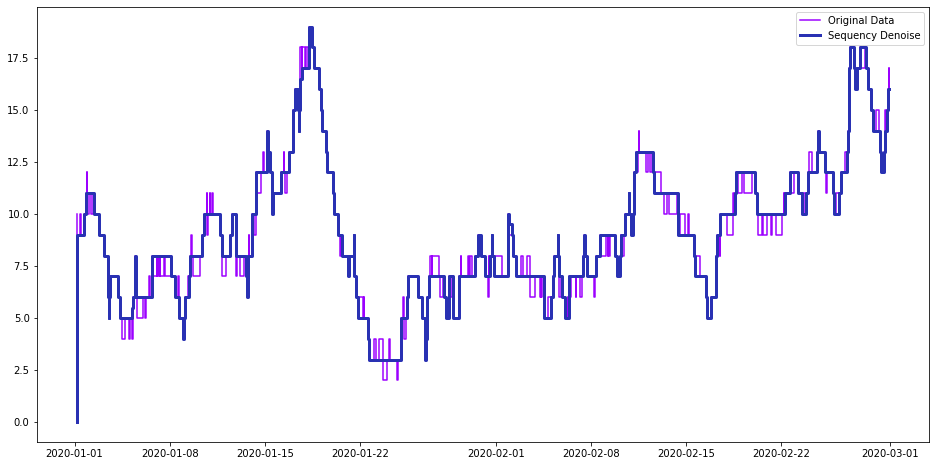

In [20]:
vq_samp = samples.vessel_queue_sample()
vq_clip = vq_samp.clip(ubound=pd.Timestamp(2020,3,1))

dn = seq.denoise(vq_clip.step_changes(),denoise_mode='range')
vq_clip_dn = Steps().add_direct(data_start=vq_clip.step_keys(convert_keys=True),data_weight=dn)

ax = vq_clip.plot(label='Original Data')
vq_clip_dn.plot(ax=ax,linewidth=3,label='Sequency Denoise')
ax.legend();


As the last item, we can take a look at the sequency spectrum for the vessel queue data. This dataset has a large number of changes and therefore the sequency range goes quite high, however it does show a number of peaks that are significantly larger than the others, indicating a number of distinct and repeating step change patterns within the data over this period.

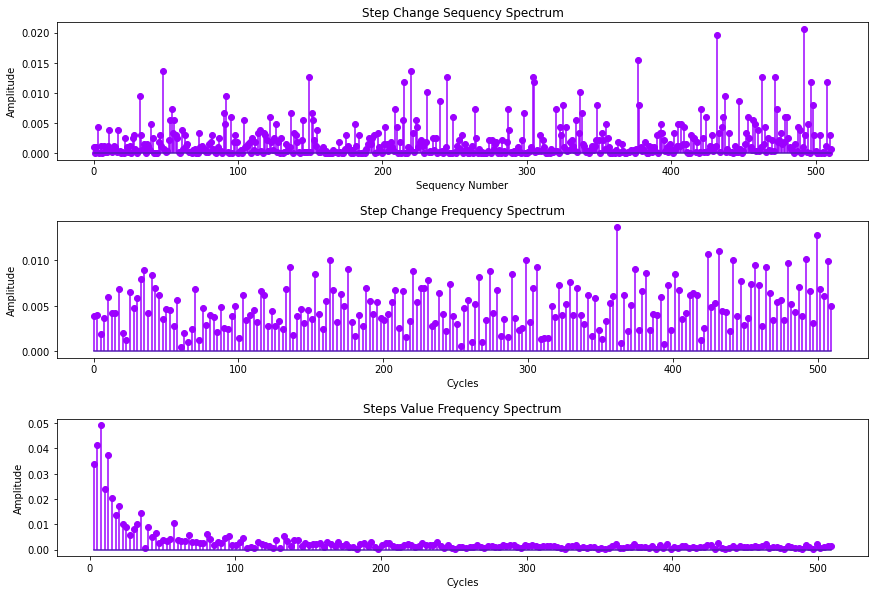

In [24]:
fig, (ax,ax2,ax3) = plt.subplots(nrows=3,figsize=(12,8))
fig.tight_layout(h_pad=4)

# Sequency object to use for analysis
vq_clip_seq = Sequency()
n,sp,l = vq_clip_seq.sequency_spectrum(vq_clip.step_changes())


ax.set_title('Step Change Sequency Spectrum')
ax.set_xlabel('Sequency Number')
ax.set_ylabel('Amplitude')
ax.stem(n,sp)

#the 1024 comes from the fact the length of the Walsh functions are 512 units, since fft +/- samples, we have double that number of intervals along the x-axis, so we set the sampling frequency to 1024 to match the Walsh transform.
fr,fsp = vq_clip_seq.frequency_spectrum(vq_clip.step_changes(),1024)

ax2.set_title('Step Change Frequency Spectrum')
ax2.set_xlabel('Cycles')
ax2.set_ylabel('Amplitude')
ax2.stem(fr,fsp)

# FFT the steps values instead of the delta changes to see the difference in the spectrum.
frv,fspv = vq_clip_seq.frequency_spectrum(vq_clip.step_values(),1024)

ax3.set_title('Steps Value Frequency Spectrum')
ax3.set_xlabel('Cycles')
ax3.set_ylabel('Amplitude')
ax3.stem(frv[1:],fspv[1:]);
